### Load the data


In [1]:
# Define input dir used by cleanup_and_merge
INPUT_DIR = "../study/results"
FIGURE_PATH_AND_NAME_PREFIX = "../figures/Fig"


import os
import json
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import json
import numpy as np
from typing import *


paper_fig_dir = "../figures/"
path_to_results = os.path.join(INPUT_DIR, 'test_Results_cleaned+mintime+fullAtt.json')


navyblue75 = "#418dcc"
navyblue50 = "#7eafdc"

THRESHOLD = 1
THRESHOLD_SEC1 = 0

In [2]:
# Load the answers

with open(path_to_results, "r") as jsonRes:
    runs = json.load(jsonRes)
    jsonRes.close()

with open("../study/rawresults/test_DB_Survey.json", "r") as f:
    survey = json.load(f)


In [3]:
with open(os.path.join(INPUT_DIR, "answers_by_user.json"), "r") as f:
    evaluations = json.load(f)


def iterate_runs():
    for run in evaluations.values():
        for attempt in range(6):
            attempt_run = [r for r in run if r["attempt"] == attempt]
            if len(attempt_run) == 0:
                continue
            yield attempt_run


def count_correct_cls(data):
    correct = []
    for run in data:
        correct.append(sum(1 if s["taskSolvedCorrectly"] else 0 for s in run))
    return correct


correct_progs = set()
buggy_progs = set()

for x in iterate_runs():
    for y in x:
        if y["expectedAnswer"] > 0:
            buggy_progs.add(y["ProgrammID"])
        else:
            correct_progs.add(y["ProgrammID"])

def iterate_examples():
    with open("../study/detector-results/gnn.jsonl", "r") as lines:
        for line in lines:
            yield json.loads(line)


def iterate_transformer_examples():
    with open("../study/detector-results/transformer.jsonl", "r") as lines:
        for line in lines:
            yield json.loads(line)


class ClassificationAndLoc():
    def __init__(this, classification, loc):
        this.classification = classification
        this.loc = loc


answers_by_task = defaultdict(list)
task_by_token = {}
program_id_to_stats = {}

for user_answers in iterate_runs():
    for answer in user_answers:
        prog = answer['ProgrammID']
        answers_by_task[prog].append(ClassificationAndLoc(
            answer['taskSolvedCorrectly'], answer['correctLineNumber']))
        task_by_token[prog] = (
            answer['token'], answer['expectedAnswer'], answer["program"].count('\n'))
        program_id_to_stats[prog] = (
            answer['token'],  answer["program"].count('\n'))


### Stats on the programs

In [4]:
tokenlist = [v[0] for v in program_id_to_stats.values()]
loclist = [v[1] for v in program_id_to_stats.values()]


def print_stats(elems, title):
    print("For {}: \n Max: {}, \t Min: {},\t Mean: {},Median: {}\n\t standard deviation {:.1f},\t variance {:.1f}".format(
        title, np.max(elems), np.min(elems), np.mean(elems), np.median(elems), np.std(elems), np.var(elems)))

print_stats(tokenlist, "Token")
print(np.std((loclist)))
print_stats(np.asarray(loclist), "LOC")



For Token: 
 Max: 348, 	 Min: 30,	 Mean: 122.50809061488673,Median: 114.0
	 standard deviation 55.6,	 variance 3088.7
7.863775348111646
For LOC: 
 Max: 45, 	 Min: 3,	 Mean: 18.265372168284788,Median: 18.0
	 standard deviation 7.9,	 variance 61.8


### Generate Figure 2


In [5]:
participants = []

pid_to_survey = {p["sessionid"]: p for p in survey}

for p in runs:
    if p["attempt"] > 1:
        continue

    participant_id = p["sessionID"]
    participants.append(pid_to_survey[participant_id])

keys = set.intersection(*[set(x.keys()) for x in participants])


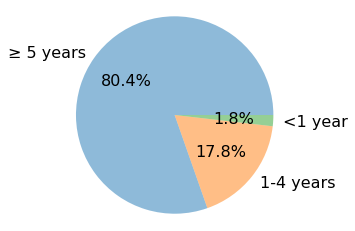

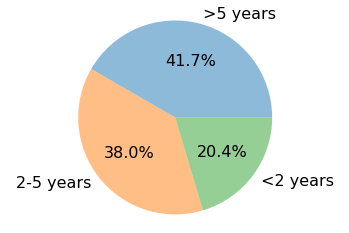

In [6]:
def compute_pie(key):
    values = [p[key] for p in participants]
    count_values = Counter(values)

    labels = count_values.keys()
    counts = [count_values[k] for k in labels]
    if key == "experience":
        labels = [">5 years", "2-5 years", "<2 years"]

    props = dict(alpha=0.5)
    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=labels, autopct='%1.1f%%', wedgeprops=props,
            shadow=False,  textprops={'fontsize': 16})
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    #plt.title(f"Ratio of {key}s across participants")
    plt.savefig(f"../figures/Fig2a.pdf")

    plt.show()


counts = [80.38, 17.8, 1.82]
labels = ["≥ 5 years", "1-4 years", "<1 year"]
props = dict(alpha=0.5)
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%', wedgeprops=props,
        shadow=False,  textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.title(f"Ratio of {key}s across participants")
plt.savefig("../figures/Fig2b.pdf")

plt.show()


compute_pie("experience")


## For Section 3.1


### Classification

In [7]:
print("Correct progs present: {}, buggy {}".format(
    len(correct_progs), len(buggy_progs)))


success_rate_cls = count_correct_cls(iterate_runs())

# Average of correct answers:
success_rate_cls_arr = np.array(success_rate_cls)

print("Users classify on average {:.2f} tasks correct, in media {:.2f}".format(
    np.mean(success_rate_cls_arr), np.median(success_rate_cls_arr)))

cor_cls_for_cor_tasks = []
cor_cls_for_wrong_tasks = []
wrong_cls_for_cor_tasks = []
wrong_cls_for_wrong_tasks = []
overall_answers = 0
answers_for_incor_tasks=0
answers_for_cor_tasks=0

for x in iterate_runs():
    for y in x:
        if y["expectedAnswer"] > 0:
            answers_for_incor_tasks+=1
            if y["taskSolvedCorrectly"]:
                cor_cls_for_wrong_tasks.append(y)
            else: wrong_cls_for_wrong_tasks.append(y)
        else:
            answers_for_cor_tasks+=1
            if y["taskSolvedCorrectly"]:
                cor_cls_for_cor_tasks.append(y)
            else: wrong_cls_for_cor_tasks.append(y)
        overall_answers +=1

print("In total {} answers for tasks, {} tasks for non-buggy and {} for buggy tasks".format( overall_answers, answers_for_cor_tasks, answers_for_incor_tasks))
print("For non-buggy tasks, human give the correct classification in {:.2f}%, the incorrect in {:.2f}%".format( len(cor_cls_for_cor_tasks) / answers_for_cor_tasks *100,  len(wrong_cls_for_cor_tasks)/answers_for_cor_tasks *100))
print("For buggy tasks, human give the correct classification in {:.2f}%, the incorrect in {:.2f}%".format( len(cor_cls_for_wrong_tasks) / answers_for_incor_tasks *100,  len(wrong_cls_for_wrong_tasks)/answers_for_incor_tasks *100))


Correct progs present: 175, buggy 134
Users classify on average 5.70 tasks correct, in media 6.00
In total 1016 answers for tasks, 561 tasks for non-buggy and 455 for buggy tasks
For non-buggy tasks, human give the correct classification in 77.36%, the incorrect in 22.64%
For buggy tasks, human give the correct classification in 63.74%, the incorrect in 36.26%


### Generate Figure 3


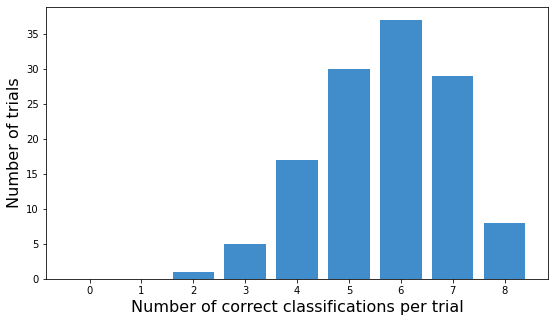

The answers in Figure 3 are: [(0, 0), (1, 0), (2, 1), (3, 5), (4, 17), (5, 30), (6, 37), (7, 29), (8, 8)]


In [8]:
from matplotlib import pyplot as plt



num_answers = []
magnitude = []
for i in range(0, 9):
    num_answers.append(i)
    magnitude.append(sum([1 for x in success_rate_cls if x == i]))
    # Count the number of correct answers given
fig, ax = plt.subplots(1, figsize=(9, 5))
plt.bar(num_answers, magnitude, color=navyblue75)
plt.xlabel("Number of correct classifications per trial",  size=16)
plt.ylabel("Number of trials", size=16)
plt.xticks(np.arange(0, 9, step=1))
plt.savefig("../figures/Fig3.pdf", bbox_inches="tight")
plt.show()

print("The answers in Figure 3 are:", list(zip(num_answers, magnitude)))



#### The role of experience for classification

In [9]:
def analyze_prefiltered_data(prefiltered_data, classification_criteria, relative=True):  
    labels = list(range(0, 9))
    for i, dataset in enumerate(prefiltered_data):
        to_process = count_correct_cls(dataset)
        magnitude = []
        abs = len(to_process)
        for j in labels:
            if relative:
                magnitude.append(
                    sum([1 for x in to_process if x == j])/abs*100)
            else:
                magnitude.append(sum([1 for x in to_process if x == j]))

        # plot data in grouped manner of bar type
        print("Trials:{},\tAverage {:.2f}, \t median {:.2f}, \tvariance {:.2f} for {}, ".format(
                abs, np.mean(to_process), np.median(to_process),  np.var(to_process), classification_criteria[i]))

analyze_prefiltered_data([
    [x for x in iterate_runs() if x[0]["exp"] == "2"],
    [x for x in iterate_runs() if x[0]["exp"] == "2-5"],
    [x for x in iterate_runs() if x[0]["exp"] == "5"]
], ["<2", "2-5", ">5", "any"])




Trials:26,	Average 5.27, 	 median 5.50, 	variance 1.97 for <2, 
Trials:53,	Average 5.77, 	 median 6.00, 	variance 1.61 for 2-5, 
Trials:48,	Average 5.85, 	 median 6.00, 	variance 1.37 for >5, 


### Localization

In [10]:
success_rate_loc = []

for run in iterate_runs():
    num_locs = sum(1 if s["correctLineNumber"]
                   else 0 for s in run if s["expectedAnswer"] >= 0)
    sum_error = sum(1 if s["expectedAnswer"] >= 1 else 0 for s in run )
    if sum_error == 0:
        continue
    success_rate_loc.append(num_locs / sum_error)



cor_cls_for_wrong_tasks = []
wrong_cls_for_wrong_tasks = []
overall_answers = 0
answers_for_incor_tasks=0

for x in iterate_runs():
    for y in x:
        if y["expectedAnswer"] <= 0: continue
        if y["expectedAnswer"] > 0:
            answers_for_incor_tasks+=1
            if y["correctLineNumber"]:
                cor_cls_for_wrong_tasks.append(y)
            else: wrong_cls_for_wrong_tasks.append(y)
        overall_answers +=1

print("For buggy tasks, developers give the correct localization in {:.2f}%, the incorrect in {:.2f}%".format( len(cor_cls_for_wrong_tasks) / answers_for_incor_tasks *100,  len(wrong_cls_for_wrong_tasks)/answers_for_incor_tasks *100))

print("Developers localize on average {:.2f} errors correct, in media {:.2f}, std {:.2f}, variance {:.2f}".format(
    np.mean(success_rate_loc), np.median(success_rate_loc), np.std(success_rate_cls), np.var(success_rate_cls)))

    

For buggy tasks, developers give the correct localization in 43.52%, the incorrect in 56.48%
Developers localize on average 0.41 errors correct, in media 0.50, std 1.28, variance 1.64


In [11]:
def compute_success_rate_loc(data):
    res = []
    num_task = []
    abs_correct_locs = 0
    abs_answers =0
    for run in data:
        num_locs = sum(1 if s["correctLineNumber"]
                       else 0 for s in run if s["expectedAnswer"] >= 0)
        sum_error = sum(1 if s["expectedAnswer"] >= 0 else 0 for s in run)
        abs_correct_locs += num_locs
        abs_answers += sum_error
        num_task.append(sum_error)
        if sum_error == 0:
            continue
        res.append(num_locs / sum_error)
    #print("Max number of wrong tasks in trial is {}".format(max(num_task)))
    return res, abs_correct_locs / abs_answers

def analyze_localization(prefiltered_data, classification_criteria, relative=True):
    step = 0.1
    labels = np.arange(0.0, 1.1, step)

    x_val = labels
    for i,  dataset in enumerate(prefiltered_data):
        success_rate_interval, correct_mean = compute_success_rate_loc(dataset)
        num_points = len(success_rate_interval)
        data = list()
        for j in labels:
            if relative:
                data.append(
                    sum([1 for x in success_rate_interval if j - step < x <= j])/num_points*100)
            else:
                data.append(
                    sum([1 for x in success_rate_interval if j - step < x <= j]))

      
        print("Trials:{},\tAverage {:.1f}%, \t median {:.2f}, \tvariance {:.2f} for {}  "
              .format(num_points,correct_mean*100, np.median(success_rate_interval),  np.var(success_rate_interval), classification_criteria[i]))


analyze_localization([
    [x for x in iterate_runs() if x[0]["exp"] == "2"],
    [x for x in iterate_runs() if x[0]["exp"] == "2-5"],
    [x for x in iterate_runs() if x[0]["exp"] == "5"]
], ["<2", "2-5", ">5", "any"])

Trials:26,	Average 31.7%, 	 median 0.29, 	variance 0.08 for <2  
Trials:52,	Average 46.0%, 	 median 0.50, 	variance 0.09 for 2-5  
Trials:46,	Average 48.0%, 	 median 0.50, 	variance 0.07 for >5  


### Influence of Code size

In [12]:

def print_data_by_task_boxplot(data_for_boxplot,  classification_criteria, labels_used, title, safefig=None, add_line=False, show_x_axis=False):

    fig, ax = plt.subplots(1, figsize=(9, 3.8))
    pos = np.arange(len(data_for_boxplot)) + 1
    medianprops = dict(linestyle='-', linewidth=3, color=navyblue75)
    meanpointprops = dict(markeredgecolor='g',
                          markerfacecolor='g')  # , alpha=0.5)
    bp = ax.boxplot(data_for_boxplot, whis=[
                    5, 95], showmeans=True, medianprops=medianprops,  meanprops=meanpointprops)

    w = [item.get_ydata() for item in bp['whiskers']]
    b = [item.get_ydata() for item in bp['boxes']]
    means = [item.get_ydata() for item in bp['means']]
    medians = [item.get_ydata() for item in bp['medians']]
    for i in range(0, len(b)):
        print("For Boxplot for {}, 25% median: {:.2f}, 75% median {:.2f}, whisker: {:.2f};{:.2f}, mean: {:.2f}, median: {:.2f}".format(
            classification_criteria[i], b[i][2], b[i][1],        w[i*2][1], w[(2*i+1)][1], means[i][0], medians[i][1]))

    if show_x_axis:
        ax.set_xlabel(
            'Classification                             Localization',size=16)
        ax.set_xticklabels(classification_criteria)
    else:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Confidence',size=16)
    # ax.set_yticks(list(labels_used))

    plt.setp(bp['whiskers'], color='k', linestyle='-')
    plt.setp(bp['fliers'], markersize=3.0)
    #plt.title(title,  fontsize=16)


    plt.plot([], [], '-', linewidth=1, color=navyblue75, label='median')
    plt.plot([], [], "^", linewidth=1, color='g', label='mean')

    
    plt.legend(loc='lower left', bbox_to_anchor=(0.32, 0.975), ncol=2)


    if add_line:
        #ax.annotate('', xy=(0.5, 0.1), xycoords='axes fraction', xytext=(0.5, -0.2), arrowprops=dict(arrowstyle="-",  linewidth=3, color='k', ))
        plt.axvline(len(data_for_boxplot)/2+0.5,
                    linewidth=3, color='k', linestyle='-', )
    if safefig is not None:
        plt.savefig(safefig,bbox_inches="tight")
    plt.show()

In [13]:

def count_correct_cls_for_task(task, classification, ):
    answers: List[ClassificationAndLoc]
    answers = answers_by_task[task]
    if (len(answers) > THRESHOLD_SEC1):
        if classification:
            return np.real(len([x for x in answers if x.classification]) / len(answers))
        else:
            return np.real(len([x for x in answers if x.loc]) / len(answers))
    else:
        return None


def count_correct_cls_per_task(dataset, classification):
    number_of_answers_per_task = []
    for task in dataset:
        res = count_correct_cls_for_task(task, classification)
        if res is not None:
            number_of_answers_per_task.append(res)
    return number_of_answers_per_task


def compute_data_for_boxplot(task_ids, classification=True):
    data_for_boxplot = []
    labels_used = set()
    for dataset in task_ids:
        to_process = count_correct_cls_per_task(dataset, classification)
        data_for_boxplot.append(np.array(to_process))
        for x in to_process:
            labels_used.add(x)
    return data_for_boxplot, labels_used


Max LOC present is: 45
For Boxplot for 1-10 LOC, 25% median: 1.00, 75% median 0.67, whisker: 0.00;1.00, mean: 0.80, median: 1.00
For Boxplot for 11-20 LOC, 25% median: 1.00, 75% median 0.50, whisker: 0.00;1.00, mean: 0.70, median: 0.75
For Boxplot for >20 LOC, 25% median: 1.00, 75% median 0.50, whisker: 0.00;1.00, mean: 0.67, median: 0.67
For Boxplot for 1-10 LOC, 25% median: 1.00, 75% median 0.38, whisker: 0.00;1.00, mean: 0.61, median: 0.63
For Boxplot for 11-20 LOC, 25% median: 0.75, 75% median 0.00, whisker: 0.00;1.00, mean: 0.45, median: 0.42
For Boxplot for >20 LOC, 25% median: 0.50, 75% median 0.00, whisker: 0.00;0.67, mean: 0.30, median: 0.33


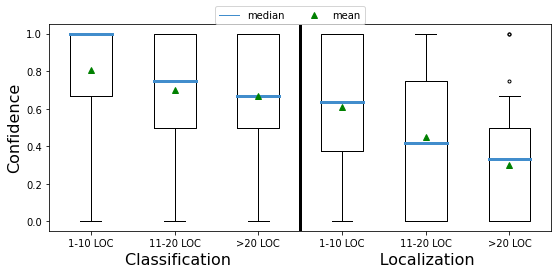

In [14]:

stepsize_loc = 10
max_LOC = 30
title_text_LOC = "{} accuracy by lines of code"
print("Max LOC present is:", max([v[2] for k, v in task_by_token.items()]))

task_ids_per_class = []
labels = []
for i in range(1, max_LOC, stepsize_loc):
    task_ids_per_class.append(
        [k for k, v in task_by_token.items() if i <= v[2] < i+stepsize_loc or (i+stepsize_loc >= max_LOC-1 and v[2] > max_LOC-1)])
    labels.append("{}-{} LOC".format(i, i+stepsize_loc-1))
labels[-1] = ">{} LOC".format(i-1)

processed_data = []
labels_used = []

processed_data, labels_used = compute_data_for_boxplot(
    task_ids_per_class, classification=True)
# Compute data for localization
task_ids_per_class = []

for i in range(1, max_LOC, stepsize_loc):
    task_ids_per_class.append(
        [k for k, v in task_by_token.items() if v[1] > 0 and (i <= v[2] < i+stepsize_loc or (i+stepsize_loc >= max_LOC-1 and v[2] > max_LOC-1))])
    labels.append("{}-{} LOC".format(i, i+stepsize_loc-1))
labels[-1] = ">{} LOC".format(i-1)

processed_data2, labels_used2 = compute_data_for_boxplot(
    task_ids_per_class, classification=False)

labels_used = labels_used.union(labels_used2)

print_data_by_task_boxplot(processed_data + processed_data2, labels,
                           labels_used, safefig="../figures/Fig4a.pdf", add_line=True, title="(a) Developer", show_x_axis=True)
num_total , num_buggy = sum([len(x) for x  in processed_data]), (sum([len(x) for x  in processed_data2]))



### Agreement of Developers on Solutions

In [15]:
compare_stats = {}

for run in iterate_runs():
    for answer in run:
        program_id = answer["ProgrammID"]

        if program_id not in compare_stats:
            compare_stats[program_id] = {"votes": [], "pure_votes": []}

        task_solved = answer["taskSolvedCorrectly"]
        correct_line = answer["correctLineNumber"]
        line_number = answer["lineNumberOfError"]

        compare_stats[program_id]["votes"].append(
            (task_solved, correct_line)
        )

        compare_stats[program_id]["pure_votes"].append(
            (line_number > 0, line_number)
        )

        compare_stats[program_id]["gt"] = answer["expectedAnswer"]



agreements = []
agreements_buggy_tasks = []

for results in compare_stats.values():
    if len(results["votes"])<=  THRESHOLD: continue
    
    vote_count = Counter([v[0] for v in results["votes"]])
    agreement = max(vote_count[True] / sum(vote_count.values()),
                    vote_count[False] / sum(vote_count.values()))
    if results["gt"] >0:
        agreements_buggy_tasks.append(agreement)
    agreements.append(agreement)


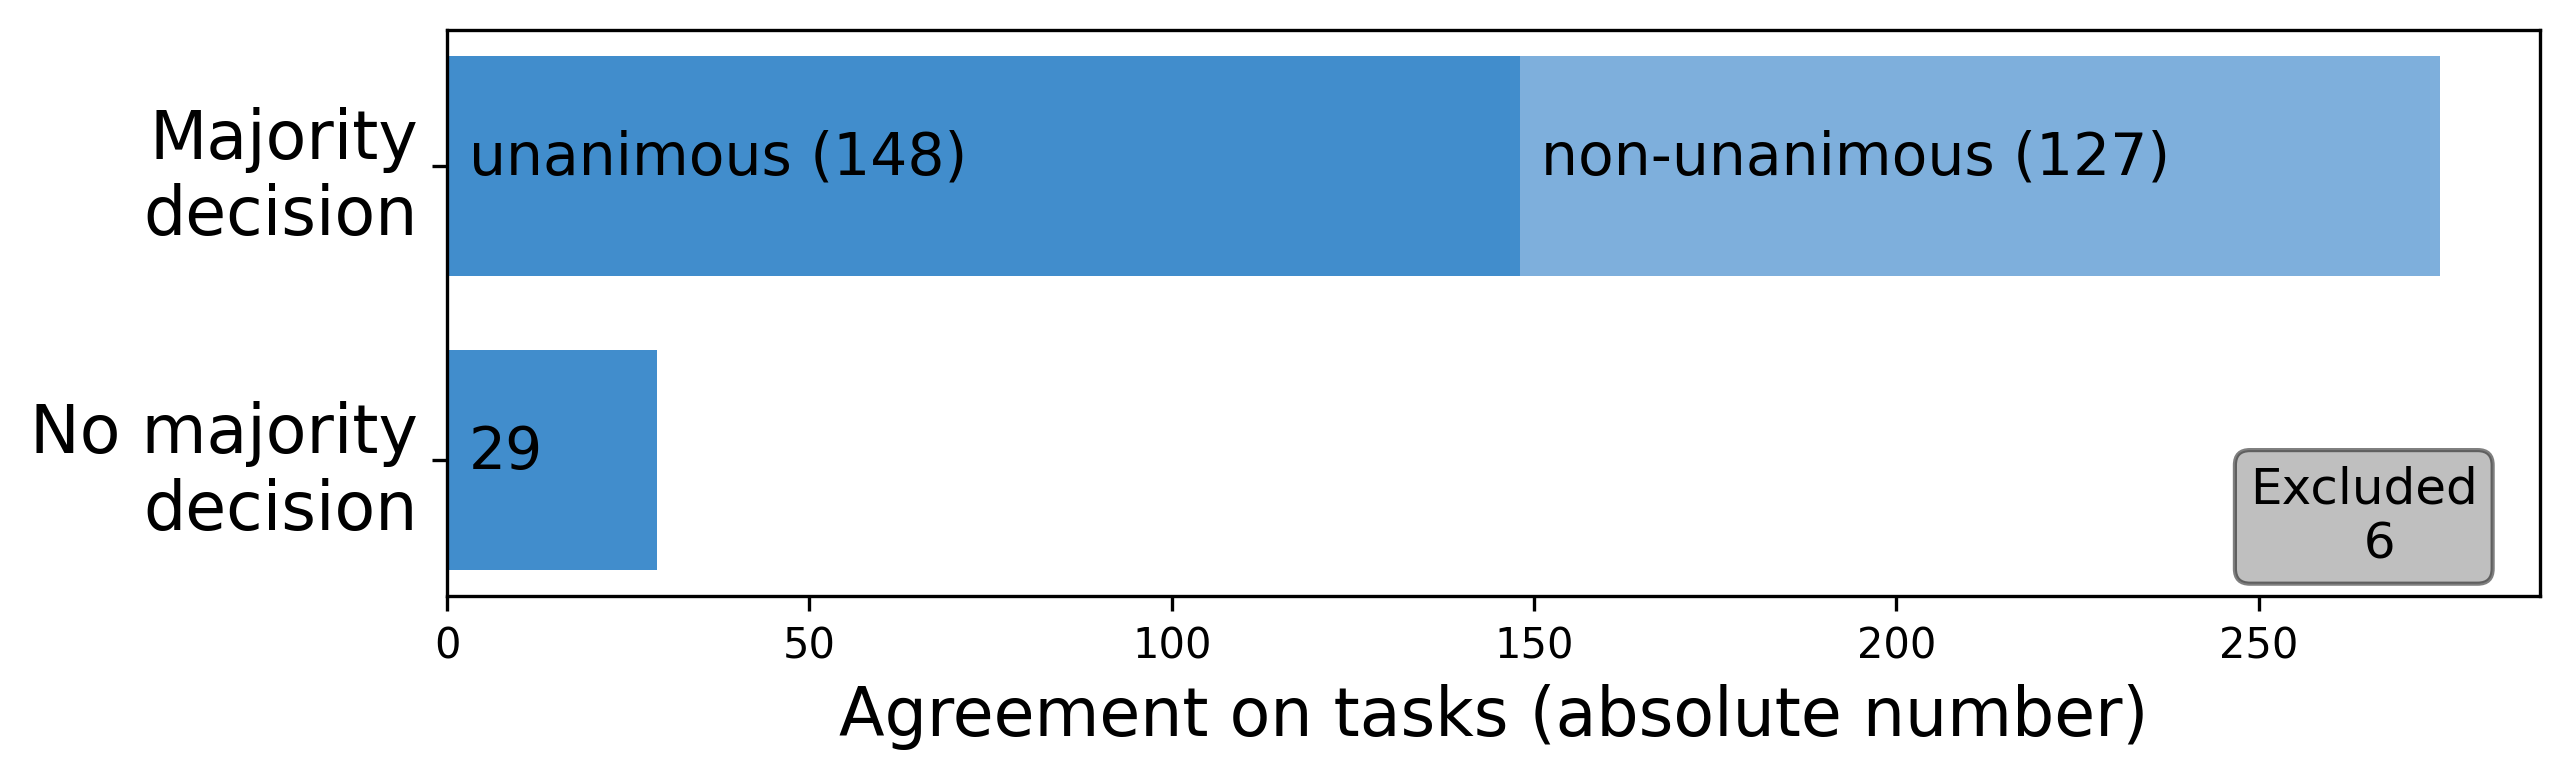

Voted equally 			[('0.01-0.50', 29), ('0.51-0.99', 127), ('1.0', 148), ('-1', 0)]
134


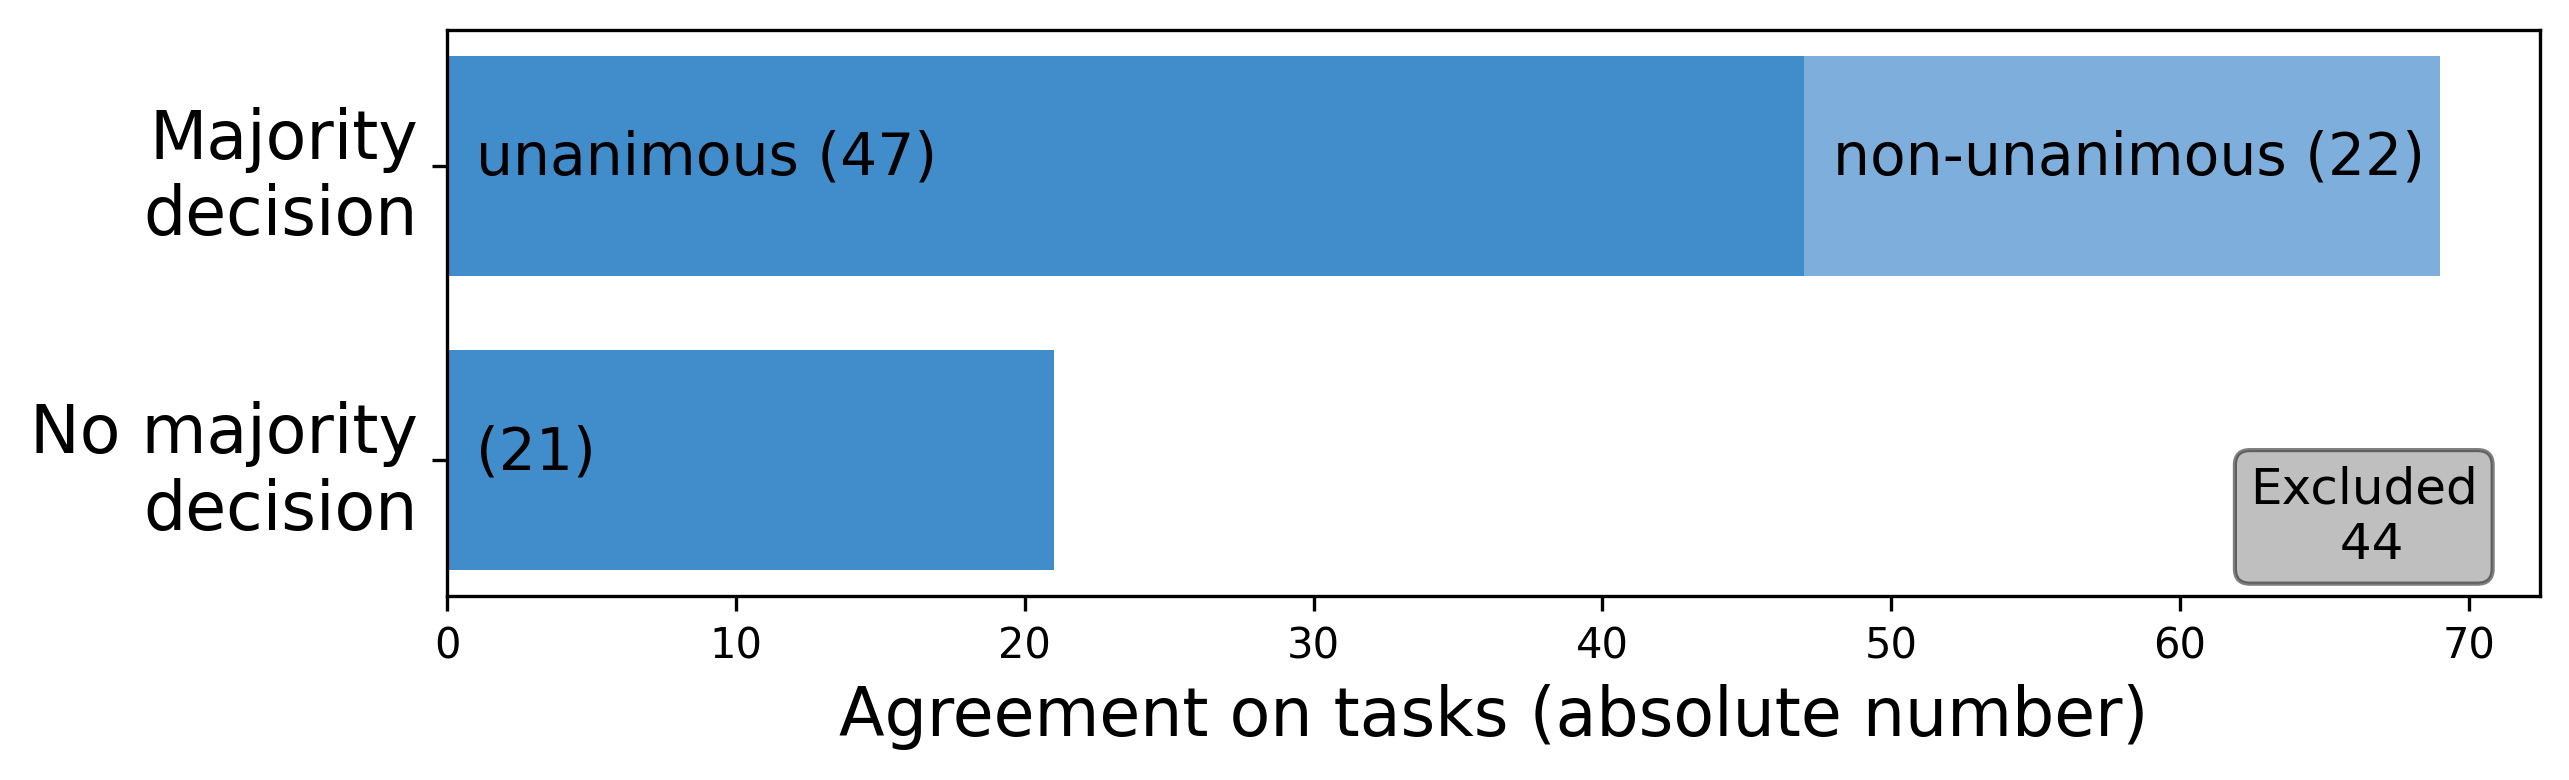

In [16]:
title_agreement = ["No majority\ndecision", "Majority\ndecision"]
height_bars = 0.15
alpha = 0.75
yshift=0.006
figlength =9
figheight =2.5
def group_agree_abs(start, end):
    return len([i for i, c in enumerate(agreements) if c >= start and c < end])
def group_agree_abs_buggy(start, end):
    return len([i for i, c in enumerate(agreements_buggy_tasks) if c >= start and c < end])

groups_agree = {}
#groups_agree["0.00"] = group_agree_abs(0, 0.01)
groups_agree["0.01-0.50"] = group_agree_abs(0.01, 0.51)
groups_agree["0.51-0.99"] = group_agree_abs(0.51, 1.0)
groups_agree["1.0"] = group_agree_abs(1.0, 1.01)
groups_agree["-1"] = 0


keys = list(groups_agree.keys())

fig, ax = plt.subplots(1,figsize=(figlength, figheight), dpi=300)
y_pos = [0, 0.2]
values = [[groups_agree["0.01-0.50"], groups_agree["1.0"]],
          [groups_agree["-1"], groups_agree["0.51-0.99"]]]

plt.barh(y_pos, values[0],  align='center',
         height=height_bars, color=navyblue75)
plt.barh(y_pos, values[1],  align='center',
         height=height_bars, left=values[0],color=navyblue50)

plt.yticks(y_pos,  title_agreement, size=16)

plt.text(3, y_pos[1]-yshift, "unanimous ({})".format(values[0][1]), size=14)
plt.text(3+values[0][1], y_pos[1]-yshift, "non-unanimous ({})".format(values[1][1]), size=14)
plt.text(3, y_pos[0]-yshift, "{}".format(values[0][0]), size=14)


text = f"Excluded\n  {6}"
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

# place a text box in upper left in axes coords
dy = 0.14
ax.text(0.916, dy, text, transform=ax.transAxes, fontsize=12,
        verticalalignment='center',
            horizontalalignment='center',
        bbox=props)


#group_agree_abs_buggy(0.01, 0.51) ,group_agree_abs_buggy(0.51, 1.0) , group_agree_abs_buggy(1.0, 1.01)
# plt.plot([group_agree_abs_buggy(0.01, 0.51),group_agree_abs_buggy(0.01, 0.51)], [ y_pos[0]+0.05,  y_pos[0]-0.05 ], color="gray" )

#plt.xlabel("Percentage of people voting equally")
plt.xlabel('Agreement on tasks (absolute number)', size=16)
#plt.title("Classification agreement of participants")
plt.savefig("../figures/Fig5a.pdf",bbox_inches="tight")
plt.show()


print("Voted equally \t\t\t{}".format(
    [(x, y) for x, y in groups_agree.items()]))



confidences = []
agreements_lines = []
print( len([x for x in compare_stats.values() if x["gt"]>0]))
ignored_no_answer=0
ignored_one_answer =0
for results in compare_stats.values():
    if(results["gt"] >= 0):
        
        vote_count = Counter([v[1] for v in results["votes"]])
        confidence = vote_count[True] / sum(vote_count.values())
        confidences.append(confidence)
for results in compare_stats.values():
    if(results["gt"] >= 0):
        vote_count = Counter([v[1] for v in results["pure_votes"] if v[1] > 0])
        if sum(vote_count.values()) <= 1:
            if sum(vote_count.values()) == 1:
                ignored_one_answer +=1
            else: ignored_no_answer+=1
            continue
        agreement = max(vote_count.values()) / sum(vote_count.values())
        agreements_lines.append(agreement)


def group_confidence(start, end):
    return len([i for i, c in enumerate(confidences) if c >= start and c < end])


def group_agreement(start, end):
    return len([i for i, c in enumerate(agreements_lines) if c >= start and c < end])


groups_agree = {}
groups_agree["0.01-0.50"] = group_agreement(0.01, 0.51)
groups_agree["0.51-0.99"] = group_agreement(0.51, 1.0)
groups_agree["1.0"] = group_agreement(1.0, 1.01)
groups_agree["-1"] = 0


keys = list(groups_agree.keys())

fig, ax = plt.subplots(1,figsize=(figlength,figheight), dpi=300)
y_pos = [0, 0.2]
values = [[groups_agree["0.01-0.50"], groups_agree["1.0"]],
          [groups_agree["-1"], groups_agree["0.51-0.99"]]]


plt.barh(y_pos, values[0],  align='center',  height=height_bars, color=navyblue75)
plt.barh(y_pos, values[1],  align='center',
         height=height_bars, left=values[0], color=navyblue50)

plt.yticks(y_pos,  title_agreement, size=16)

plt.text(1, y_pos[1]-yshift, "unanimous ({})".format(values[0][1]), size=14)
plt.text(1+values[0][1], y_pos[1]-yshift, "non-unanimous ({})".format(values[1][1]), size=14)
plt.text(1, y_pos[0]-yshift, "({})".format(values[0][0]), size=14)


text = f"Excluded\n {ignored_no_answer+ignored_one_answer}"
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

# place a text box in upper left in axes coords
dy = 0.14
ax.text(0.916, dy, text, transform=ax.transAxes, fontsize=12,
        verticalalignment='center',
            horizontalalignment='center',
        bbox=props)


#plt.xlabel("Percentage of people voting equally")
plt.xlabel('Agreement on tasks (absolute number)', size=16)
#plt.title("Classification agreement of participants")
plt.savefig("../figures/Fig5b.pdf",bbox_inches="tight")
plt.show()



### Compute Boxplots for GNN and Transformer

In [17]:
compare_stats = {}
LOC_CLASSES = [0, 10, 20, 50]

for run in iterate_runs():
    for answer in run:
        program_id = answer["ProgrammID"]

        if program_id not in compare_stats:
            compare_stats[program_id] = {"num_votes": 0}

        compare_stats[program_id]["num_votes"] += 1

        compare_stats[program_id]["gt"] = answer["expectedAnswer"]
        compare_stats[program_id]["program"] = answer["program"]
        compare_stats[program_id]["loc"] = len(answer["program"].splitlines())

for key in list(compare_stats.keys()):
    if compare_stats[key]["num_votes"] <= THRESHOLD:
        del compare_stats[key]

for task_id, machine_answer in enumerate(iterate_examples()):
    if task_id not in compare_stats:
        continue

    compare_stats[task_id]["predictions"] = machine_answer["predictions"]

for task_id, transformer_answer in enumerate(iterate_transformer_examples()):
    if task_id not in compare_stats:
        continue

    compare_stats[task_id]["transformer_predictions"] = transformer_answer["predictions"]


### Generate Boxplot for GNN


For Boxplot for 1 - 10 LOC, 25% median: 1.00, 75% median 0.39, whisker: 0.00;1.00, mean: 0.69, median: 0.93
For Boxplot for 11 - 20 LOC, 25% median: 1.00, 75% median 0.04, whisker: 0.00;1.00, mean: 0.63, median: 0.92
For Boxplot for > 20 LOC, 25% median: 0.98, 75% median 0.00, whisker: 0.00;1.00, mean: 0.49, median: 0.53
For Boxplot for 1 - 10 LOC, 25% median: 1.00, 75% median 0.00, whisker: 0.00;1.00, mean: 0.69, median: 1.00
For Boxplot for 11 - 20 LOC, 25% median: 1.00, 75% median 0.00, whisker: 0.00;1.00, mean: 0.45, median: 0.11
For Boxplot for > 20 LOC, 25% median: 0.84, 75% median 0.00, whisker: 0.00;1.00, mean: 0.27, median: 0.00


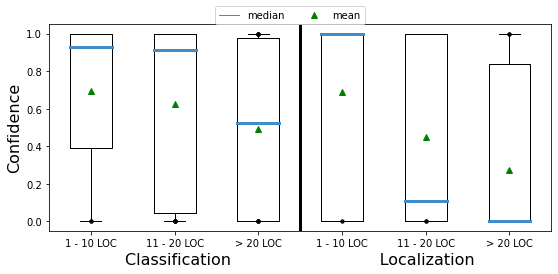

In [18]:
classification = []
labels_used = set()
data_for_boxplot = []

for i in range(1, len(LOC_CLASSES)):
    min_token = LOC_CLASSES[i - 1] + 1
    max_token = LOC_CLASSES[i]

    data = []

    for task_id, stats in compare_stats.items():
        token_len = stats["loc"]
        if min_token > token_len or max_token < token_len:
            continue

        cls_prob = 0.0

        for prediction in stats["predictions"]:
            if prediction["buggy"] == (stats["gt"] > 0):
                cls_prob = prediction["prob"]
                break

        data.append(cls_prob)

    data_for_boxplot.append(np.array(data))
    labels_used = labels_used.union(set(data))
    classification.append(f"{min_token} - {max_token} LOC")

classification[-1] = f"> {LOC_CLASSES[-2] } LOC"

for i in range(1, len(LOC_CLASSES)):
    min_token = LOC_CLASSES[i - 1] + 1
    max_token = LOC_CLASSES[i]

    data = []

    for task_id, stats in compare_stats.items():
        if stats["gt"] < 0:
            continue
        token_len = stats["loc"]
        if min_token > token_len or max_token < token_len:
            continue

        gnn_predictions = stats["predictions"]
        data_added = False
        for pred in gnn_predictions:
            if  pred["line_num"] == stats["gt"]:
                data_added = True
                data.append(pred["prob"] )
                break
        if not data_added:
            # Maschine has not assigned any prob to the error line
            data.append(0)


    data_for_boxplot.append(np.array(data))
    labels_used = labels_used.union(set(data))
    classification.append(f"{min_token} - {max_token} LOC")

classification[-1] = f"> {LOC_CLASSES[-2] } LOC"

labels_used = {0.0, 0.25, 0.333, 0.5, 0.6, 0.667, 0.750, 0.80, 1.0}

print_data_by_task_boxplot(data_for_boxplot,  classification, labels_used,
                           safefig="../figures/Fig4b.pdf", add_line=True, title="(b) GNN", show_x_axis=True)


### Generate Boxplot for Transformer

For Boxplot for 1 - 10 LOC, 25% median: 0.95, 75% median 0.46, whisker: 0.01;1.00, mean: 0.62, median: 0.62
For Boxplot for 11 - 20 LOC, 25% median: 0.73, 75% median 0.20, whisker: 0.00;1.00, mean: 0.47, median: 0.44
For Boxplot for > 20 LOC, 25% median: 0.48, 75% median 0.07, whisker: 0.00;0.77, mean: 0.31, median: 0.29
For Boxplot for 1 - 10 LOC, 25% median: 1.00, 75% median 0.01, whisker: 0.00;1.00, mean: 0.64, median: 0.98
For Boxplot for 11 - 20 LOC, 25% median: 0.96, 75% median 0.00, whisker: 0.00;1.00, mean: 0.40, median: 0.08
For Boxplot for > 20 LOC, 25% median: 0.07, 75% median 0.00, whisker: 0.00;1.00, mean: 0.16, median: 0.00


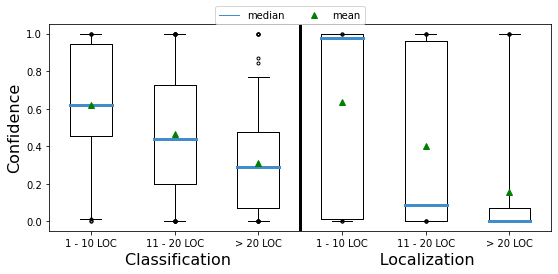

In [19]:
classification = []
labels_used = set()
data_for_boxplot = []

for i in range(1, len(LOC_CLASSES)):
    min_token = LOC_CLASSES[i - 1] + 1
    max_token = LOC_CLASSES[i]

    data = []

    for task_id, stats in compare_stats.items():
        token_len = stats["loc"]
        if min_token > token_len or max_token < token_len:
            continue

        cls_prob = 0.0

        for prediction in stats["transformer_predictions"]:
            if prediction["buggy"] == (stats["gt"] > 0):
                cls_prob = prediction["prob"]
                break

        data.append(cls_prob)

    data_for_boxplot.append(np.array(data))
    labels_used = labels_used.union(set(data))
    classification.append(f"{min_token} - {max_token} LOC")

classification[-1] = f"> {LOC_CLASSES[-2] } LOC"

for i in range(1, len(LOC_CLASSES)):
    min_token = LOC_CLASSES[i - 1] + 1
    max_token = LOC_CLASSES[i]

    data = []
    for task_id, stats in compare_stats.items():
        if stats["gt"] < 0:
            continue
        token_len = stats["loc"]
        if min_token > token_len or max_token < token_len:
            continue


        transformer_predictions = stats["transformer_predictions"]
        data_added = False
        for transformer_prediction in transformer_predictions:
            if  transformer_prediction["line_num"] == stats["gt"]:
                data_added = True
                data.append(transformer_prediction["prob"] )
                break
        if not data_added:
            # Maschine has not assigned any prob to the error line
            data.append(0)

    data_for_boxplot.append(np.array(data))
    labels_used = labels_used.union(set(data))
    classification.append(f"{min_token} - {max_token} LOC")

classification[-1] = f"> {LOC_CLASSES[-2] } LOC"

labels_used = {0.0, 0.25, 0.333, 0.5, 0.6, 0.667, 0.750, 0.80, 1.0}

print_data_by_task_boxplot(data_for_boxplot,  classification, labels_used, "(c) Transformer",
                           safefig="../figures/Fig4c.pdf", add_line=True, show_x_axis=True)


## Generation of Venn-Diagrams

In [20]:
from matplotlib_venn import venn3, venn3_circles




def hm_venn3(subsets, set_labels, outside = 0, title = None, title_pad = None, outside_label = "Undetected", no_majority = 0):
    total = sum(subsets) + outside + no_majority

    splt, ax = plt.subplots()

    vd3 = venn3(subsets = subsets,
                    set_labels = set_labels)
    
    for text in vd3.set_labels:
        if text is None: continue
        text.set_fontsize(14)
    for text in vd3.subset_labels:
        if text is None: continue
        text.set_fontsize(10)

    venn3_circles(subsets = subsets,
                    linestyle="--",
                    linewidth=2, color="grey")
    
    if title is not None:
        plt.title(title % total, fontsize = 14, pad = title_pad)

    dy = 0.05

    if outside > 0:
        text = f"{outside_label}\n{outside}"
        props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, dy, text, transform=ax.transAxes, fontsize=10,
                verticalalignment='center',
                 horizontalalignment='center',
                bbox=props)

    if no_majority > 0:
        text = f"No majority\n{no_majority}"
        props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.90, dy, text, transform=ax.transAxes, fontsize=10,
                verticalalignment='center',
                 horizontalalignment='center',
                bbox=props)

In [21]:
ignore_ties = True
count_ties_as_majority = False

THRESHOLD = 1

compare_stats = {}

for run in iterate_runs():
    for answer in run:
        program_id = answer["ProgrammID"]

        if program_id not in compare_stats:
            compare_stats[program_id] = {"votes": [], "pure_votes": []}

        task_solved  = answer["taskSolvedCorrectly"]
        correct_line = answer["correctLineNumber"] 
        line_number  = answer["lineNumberOfError"]

        compare_stats[program_id]["votes"].append(
            (task_solved, correct_line)
        )

        compare_stats[program_id]["pure_votes"].append(
            (line_number > 0, line_number)
        )

        compare_stats[program_id]["gt"] = answer["expectedAnswer"]
        compare_stats[program_id]["program"] = answer["program"]

for key in list(compare_stats.keys()):
    if len(compare_stats[key]["votes"]) <= THRESHOLD:
        del compare_stats[key]

for task_id, machine_answer in enumerate(iterate_examples()):    
    if task_id not in compare_stats: continue

    compare_stats[task_id]["predictions"] = machine_answer["predictions"]

for task_id, transformer_answer in enumerate(iterate_transformer_examples()):
    if task_id not in compare_stats: continue

    compare_stats[task_id]["transformer_predictions"] = transformer_answer["predictions"]


for task_id, stats in compare_stats.items():
    print(task_id, stats)
    break


25 {'votes': [(False, False), (True, True), (True, True), (True, True)], 'pure_votes': [(False, -2), (True, 5), (True, 5), (True, 5)], 'gt': 5, 'program': '  public TiledDrawable getTiledDrawable(String name) {\r\n    TiledDrawable tiled = optional(name, TiledDrawable.class);\r\n    if (tiled != null) return tiled;\r\n\r\n    Drawable drawable = optional(name, Drawable.class);\r\n    if (tiled != null) {\r\n      if (!(drawable instanceof TiledDrawable)) {\r\n        throw new GdxRuntimeException(\r\n            "Drawable found but is not a TiledDrawable: "\r\n                + name\r\n                + ", "\r\n                + drawable.getClass().getName());\r\n      }\r\n      return tiled;\r\n    }\r\n\r\n    tiled = new TiledDrawable(getRegion(name));\r\n    add(name, tiled, TiledDrawable.class);\r\n    return tiled;\r\n  }\r\n', 'predictions': [{'buggy': True, 'line_num': 5, 'prob': 1.0}, {'buggy': False, 'line_num': -1, 'prob': 3.03358094640507e-10}, {'buggy': True, 'line_num': 

### Figure 6a


All correct: 43
Human - TR: 5
Human - GNN: 17
TR - GNN: 11
Only human: 17
Only GNN: 14
Only TR: 3
All failed: 14
Human:82
GNN:85
TR:62


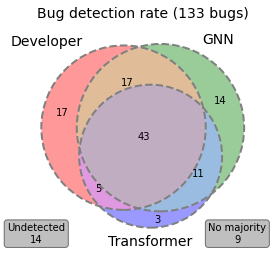

In [22]:

from collections import Counter

all_correct   = 0

human_correct = 0
ml_correct    = 0
tr_correct    = 0

human_ml_correct = 0
human_tr_correct = 0
ml_tr_correct    = 0

all_failed = 0
count_all = 0

no_majority = 0


for results in compare_stats.values():
    if results["gt"] < 0: continue
    vote_count = Counter([v[0] for v in results["votes"]])

    if ignore_ties and vote_count[True] == vote_count[False]: 
        no_majority += 1
        continue
    count_all += 1
    
    if count_ties_as_majority:
        human_is_correct = vote_count[True] >= vote_count[False]
    else: 
        human_is_correct = vote_count[True] > vote_count[False]

    prediction = results["predictions"][0]
    ml_is_correct = prediction["buggy"] == (results["gt"] > 0)

    tr_prediction = results["transformer_predictions"][0]
    tr_is_correct = tr_prediction["buggy"] == (results["gt"] > 0)

    if human_is_correct:
        if ml_is_correct:
            if tr_is_correct:
                all_correct += 1
            else:
                human_ml_correct += 1
        else:
            if tr_is_correct:
                human_tr_correct += 1
            else:
                human_correct += 1
    else:
        if ml_is_correct:
            if tr_is_correct:
                ml_tr_correct += 1
            else:
                ml_correct += 1
        else:
            if tr_is_correct:
                tr_correct += 1
            else:
                all_failed += 1

print("All correct: %d" % (all_correct))
print("Human - TR: %d" % (human_tr_correct))
print("Human - GNN: %d" % (human_ml_correct))
print("TR - GNN: %d" % (ml_tr_correct))
print("Only human: %d" % (human_correct))
print("Only GNN: %d" % (ml_correct))
print("Only TR: %d" % (tr_correct))
print("All failed: %d" % (all_failed))

print("Human:%d" %  (all_correct+ human_correct+human_tr_correct+human_ml_correct))
print("GNN:%d" %  (all_correct+ ml_correct+ml_tr_correct+human_ml_correct))
print("TR:%d" %  (all_correct+ tr_correct+ml_tr_correct+human_tr_correct))

hm_venn3(
subsets = (human_correct, ml_correct, human_ml_correct, tr_correct, human_tr_correct, ml_tr_correct, all_correct),
set_labels = ("Developer", "GNN", "Transformer"),
outside = all_failed,
title = "Bug detection rate (%d bugs)",
no_majority = no_majority,
title_pad = 9
)
plt.savefig("../figures/Fig6a.pdf", bbox_inches='tight')


### Figure 6b

All correct: 1
Human - TR: 0
Human - GNN: 12
TR - GNN: 9
Only human: 5
Only GNN: 36
Only TR: 6
All failed: 82


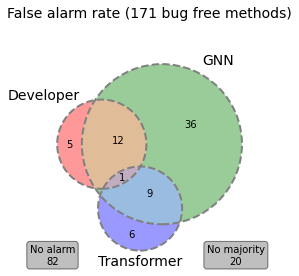

In [23]:



from collections import Counter

all_correct   = 0

human_correct = 0
ml_correct    = 0
tr_correct    = 0

human_ml_correct = 0
human_tr_correct = 0
ml_tr_correct    = 0

all_failed = 0
count_all = 0
no_majority = 0


for results in compare_stats.values():
    if results["gt"] >= 0: continue
    vote_count = Counter([v[0] for v in results["votes"]])

    if ignore_ties and vote_count[True] == vote_count[False]: 
        no_majority += 1
        continue
    count_all += 1
    
    if count_ties_as_majority:
        human_is_correct = vote_count[False] >= vote_count[True]
    else: human_is_correct =vote_count[False] > vote_count[True]

    prediction = results["predictions"][0]
    ml_is_correct = prediction["buggy"] != (results["gt"] > 0)

    tr_prediction = results["transformer_predictions"][0]
    tr_is_correct = tr_prediction["buggy"] != (results["gt"] > 0)

    if human_is_correct:
        if ml_is_correct:
            if tr_is_correct:
                all_correct += 1
            else:
                human_ml_correct += 1
        else:
            if tr_is_correct:
                human_tr_correct += 1
            else:
                human_correct += 1
    else:
        if ml_is_correct:
            if tr_is_correct:
                ml_tr_correct += 1
            else:
                ml_correct += 1
        else:
            if tr_is_correct:
                tr_correct += 1
            else:
                all_failed += 1

print("All correct: %d" % (all_correct))
print("Human - TR: %d" % (human_tr_correct))
print("Human - GNN: %d" % (human_ml_correct))
print("TR - GNN: %d" % (ml_tr_correct))
print("Only human: %d" % (human_correct))
print("Only GNN: %d" % (ml_correct))
print("Only TR: %d" % (tr_correct))
print("All failed: %d" % (all_failed))

hm_venn3(
subsets = (human_correct, ml_correct, human_ml_correct, tr_correct, human_tr_correct, ml_tr_correct, all_correct),
set_labels = ("Developer", "GNN", "Transformer"),
outside = all_failed,
title = "False alarm rate (%d bug free methods)",
outside_label = "No alarm",
no_majority = no_majority,
title_pad = 31,
)
plt.savefig("../figures/Fig6b.pdf", bbox_inches='tight')

### Figure 6c

All correct: 23
Human - TR: 6
Human - GNN: 5
TR - GNN: 9
Only human: 15
Only GNN: 11
Only TR: 6
All failed: 42
Tasks missclassifed by all: 25
Human:49, 41.9%
GNN:48, 41.0% 
TR:44, 37.6%


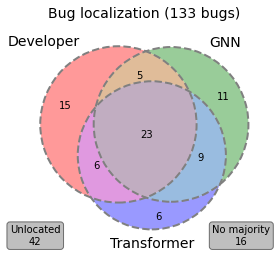

In [24]:
from collections import Counter

all_correct   = 0

human_correct = 0
ml_correct    = 0
tr_correct    = 0

human_ml_correct = 0
human_tr_correct = 0
ml_tr_correct    = 0

all_failed = 0
count_all = 0
all_missclassified =0

no_majority = 0

for results in compare_stats.values():
    if results["gt"] < 0: continue
    vote_count = Counter([v[1] for v in results["votes"]])
    if ignore_ties and vote_count[True] == vote_count[False]: 
        no_majority += 1
        continue
    count_all += 1
    
    if count_ties_as_majority:
        human_is_correct = vote_count[True] >= vote_count[False]
    else: human_is_correct = vote_count[True] > vote_count[False]

    prediction = results["predictions"][0]
    ml_is_correct = prediction["line_num"] == results["gt"]

    tr_prediction = results["transformer_predictions"][0]
    tr_is_correct = tr_prediction["line_num"] == results["gt"]
    

    if human_is_correct:
        if ml_is_correct:
            if tr_is_correct:
                all_correct += 1
            else:
                human_ml_correct += 1
        else:
            if tr_is_correct:
                human_tr_correct += 1
            else:
                human_correct += 1
    else:
        if ml_is_correct:
            if tr_is_correct:
                ml_tr_correct += 1
            else:
                ml_correct += 1
        else:
            if tr_is_correct:
                tr_correct += 1
            else:
                ctr = Counter([v[0] for v in results["votes"]])
                if ctr[False] > ctr[True] : #and  prediction["buggy"] and tr_prediction["buggy"] :
                    all_missclassified +=1
                all_failed += 1

print("All correct: %d" % (all_correct))
print("Human - TR: %d" % (human_tr_correct))
print("Human - GNN: %d" % (human_ml_correct))
print("TR - GNN: %d" % (ml_tr_correct))
print("Only human: %d" % (human_correct))
print("Only GNN: %d" % (ml_correct))
print("Only TR: %d" % (tr_correct))
print("All failed: %d" % (all_failed))

print("Tasks missclassifed by all: %d" % all_missclassified )

print("Human:{}, {:.1f}%".format(  (all_correct+ human_correct+human_tr_correct+human_ml_correct),(all_correct+ human_correct+human_tr_correct+human_ml_correct) / count_all *100))
print("GNN:{}, {:.1f}% ".format(  (all_correct+ ml_correct+ml_tr_correct+human_ml_correct),  (all_correct+ ml_correct+ml_tr_correct+human_ml_correct) / count_all*100))
print("TR:{}, {:.1f}%".format( (all_correct+ tr_correct+ml_tr_correct+human_tr_correct),  (all_correct+ tr_correct+ml_tr_correct+human_tr_correct) / count_all*100))


hm_venn3(
subsets = (human_correct, ml_correct, human_ml_correct, tr_correct, human_tr_correct, ml_tr_correct, all_correct),
set_labels = ("Developer", "GNN", "Transformer"),
outside = all_failed,
title = "Bug localization (%d bugs)",
outside_label = "Unlocated",
no_majority = no_majority,
title_pad = 11,
)
plt.savefig("../figures/Fig6c.pdf", bbox_inches='tight')